In [1]:
from PIL import Image
import nibabel
import os, pathlib, numpy, json
import h5py
from fenics import *
from fenics_adjoint import *

In [2]:
import Pic2Fen
import mri_utils.MRI2FEM as MRI2FEM

In [3]:
from parse import parse

In [4]:
jobpath = pathlib.Path("/home/bastian/Oscar-Image-Registration-via-Transport-Equation/systematicdebug/")
resultpath = pathlib.Path("/home/bastian/D1/systematicdebugging/")
IMAGETYPE = "rocket"

In [5]:
jobpath = pathlib.Path("/home/bastian/Oscar-Image-Registration-via-Transport-Equation/cubedebugging/")
resultpath = pathlib.Path("/home/bastian/D1/cubedebugging/")
IMAGETYPE = "cube"

In [6]:
def scan_logfile(foldername):
    for job in sorted(os.listdir(jobpath)):

        if not job.endswith(".out"):

            continue
        jobid = int(job.replace(".out", ""))

        jobfile = jobpath / job

        jobid = str(pathlib.Path(job).stem)

        file1 = open(jobfile, 'r')
        file2 = open(jobpath / (jobid + "_log_python_srun.txt"))
        log = file2.readlines()
        Lines = file1.readlines()
        found_job = False
        for line in Lines:

            if foldername in line:
                found_job=True
        if found_job:
            for line in log:
                if "At iterate    0" in line:
                    line = line.replace(" ", "")
                    return parse("Atiterate0f={}|projg|={}", line)[0]
        # "At iterate    0    f=  3.07133D-02    |proj g|=  6.14069D-04"

In [7]:
for job in sorted(os.listdir(jobpath)):

    if not job.endswith(".out"):

        continue
    # jobid = int(job.replace("_log_python_srun.txt", ""))
    jobid = int(job.replace(".out", ""))
    # print(jobid)
    if jobid < 420480:
        continue

    jobfile = jobpath / job

    jobid = str(pathlib.Path(job).stem)

    file1 = open(jobfile, 'r')
    file2 = open(jobpath / (jobid + "_log_python_srun.txt"))
    log = file2.readlines()
    
    for logline in log:
        #print(logline)
        pass
    try:
        Lines = file1.readlines()
    except UnicodeDecodeError:
        print("UnicodeDecodeError at job", job, "will continue to next job")
        continue
    
    succes = False
    failure = False
    
    for line in Lines:

        if "success".lower() in line.lower():
            succes = True
        if "error".lower() in line.lower():
            failure = True
            
    print("-"*80)
    if succes:
        print(jobid, "success")
    else:
        print(jobid, "running")
    if failure:
        print(jobid, "failure")

--------------------------------------------------------------------------------
421685 success
--------------------------------------------------------------------------------
421687 success
--------------------------------------------------------------------------------
421688 success
--------------------------------------------------------------------------------
421690 success
--------------------------------------------------------------------------------
421692 success
--------------------------------------------------------------------------------
421693 success
--------------------------------------------------------------------------------
421696 success
--------------------------------------------------------------------------------
421743 success
--------------------------------------------------------------------------------
421744 running
421744 failure
--------------------------------------------------------------------------------
421760 running
421760 failure
----------

In [8]:
folders = [resultpath / pathlib.Path(x) for x in os.listdir(resultpath)]
folders = [x for x in folders if x.is_dir() and "." not in str(x)]

In [9]:
datadir = pathlib.Path("/home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d")
codedir = pathlib.Path("/home/bastian/Oscar-Image-Registration-via-Transport-Equation")

In [10]:
def plot_all(inputimage, finalimage, targetimage):
    fig, ax = plt.subplots(1,5)
    ax[0].set_title("Input")
    
    imgs = [finalimage, targetimage, inputimage]
    if 255 == max([x.max() for x in imgs]):
        print("Assuming images, normalizing by 255")
        for idx, im in enumerate(imgs):
            if imgs[idx].max() > 2:
                imgs[idx] = imgs[idx].astype(float)
                imgs[idx] *= (1 / 255)
                assert imgs[idx].max() <= 1, "failed here"
    
    finalimage, targetimage, inputimage = imgs[0], imgs[1], imgs[2]
    
    assert np.max(inputimage) <= 1
    vmax = max(np.max(inputimage), np.max(targetimage))
    vmin = min(np.min(inputimage), np.min(targetimage))
    print("vmax=", vmax, "vmin", vmin)
            
    im0 = ax[0].imshow(np.clip(inputimage, vmin, vmax), vmin=vmin, vmax=vmax, cmap="Greys_r")   
        
    ax[1].set_title("Final")
    ax[1].imshow(np.clip(finalimage, vmin, vmax), vmin=vmin, vmax=vmax, cmap="Greys_r")   
                 # finalimage, vmin=0, vmax=vmax, cmap="Greys_r")

    ax[-3].set_title("Input-Final")
    ax[-3].imshow(np.clip(np.abs(inputimage-finalimage), vmin, vmax), vmin=vmin, vmax=vmax, cmap="Greys_r")   
    print("|In-Target|", format(np.mean(np.abs(inputimage-targetimage)), ".3f"))
    
    ax[-2].set_title("Target-Final")
    ax[-2].imshow(np.clip(np.abs(targetimage-finalimage), vmin, vmax), vmin=vmin, vmax=vmax, cmap="Greys_r")   
    print("|Target-Final|", format(np.mean(np.abs(targetimage-finalimage)), ".3f"))
    
    ax[-1].set_title("Target")
    ax[-1].imshow(np.clip(targetimage, vmin, vmax), vmin=vmin, vmax=vmax, cmap="Greys_r")   
    for a in ax:
        a.yaxis.set_ticks_position("none")
        a.xaxis.set_ticks_position('none')
        a.set_yticks([])
        a.set_xticks([])
        
        #a.spines.right.set_visible(False)
        #a.spines.top.set_visible(False)
        
        
    plt.show()

In [11]:
def input_target(foldername, imgtype, always_load_image=False, normalize = True):

    if imgtype == "cube":
        FName1 = str(datadir / "input.mgz")
        FName2 = str(datadir / "target.mgz")
        
        image1 = nibabel.load(FName1)
        inputimage1 = np.squeeze(image1.get_fdata())
        if normalize:
            inputimage1 /= inputimage1.max()
        
        image2 = nibabel.load(FName2)
        targetimage1 = np.squeeze(image2.get_fdata())
        if normalize:
            targetimage1 /= targetimage1.max()
            
    if "Pic2FEN" in str(foldername) and imgtype == "cube":
    
        inputimage1 = np.rot90(inputimage1)
        targetimage1 = np.rot90(targetimage1)
        
        mesh1, img1, N1 = Pic2Fen.Pic2FEM(FName1, mesh=None, degree=1)
        Space = FunctionSpace(mesh1, "DG", 1)

        if normalize:
            print(np.max(img1.vector()[:]))
            img1.vector()[:] /= np.max(img1.vector()[:])
            img1.vector()[:] = np.where(img1.vector()[:] < 0, 0, img1.vector()[:])

        img1 = project(sqrt(inner(img1, img1)), Space)
    
        mesh2, img2, N2 = Pic2Fen.Pic2FEM(FName2, mesh=None, degree=1)
        Space2 = FunctionSpace(mesh2, "DG", 1)

        if normalize:
            print(np.max(img2.vector()[:]))
            img2.vector()[:] /= np.max(img2.vector()[:])
            img2.vector()[:] = np.where(img2.vector()[:] < 0, 0, img2.vector()[:])

        img2 = project(sqrt(inner(img2, img2)), Space2)
    
        nx, ny = targetimage1.shape[0], targetimage1.shape[1]
        inputimage = np.zeros((nx, ny))
        targetimage = np.zeros((nx, ny))
                
        for x in range(nx):
            for y in range(ny):
                inputimage[x,y] = img1(x, y)
                targetimage[x,y] = img2(x, y)
                
        print("--max", img1.vector()[:].max(), img2.vector()[:].max())
        print("--max", targetimage.max())
        print("Populated Input and Target images by function values")
        print("Diff in input", np.mean(inputimage1-inputimage))
        print("Diff in target", np.mean(targetimage1-targetimage))
    
    
    if "MRI2FEM" in str(foldername) and imgtype == "cube":

        mesh1, img1, N1 = MRI2FEM.read_image(hyperparameters={"image":FName1, "state_functionspace": "DG", "state_functiondegree":1}, 
                             name="image", mesh=None, normalize=normalize)

        mesh2, img2, N2 = MRI2FEM.read_image(hyperparameters={"image":FName2, "state_functionspace": "DG", "state_functiondegree":1}, 
                                     name="image", mesh=None, normalize=normalize)
        
        nx, ny = image2.shape[0], image2.shape[1]
        inputimage = np.zeros((nx, ny))
        targetimage = np.zeros((nx, ny))
                
        for x in range(nx):
            for y in range(ny):
                Lx, Ly = nx, ny 
                inputimage[x,y] = img1(x / Lx, y / Ly)
                targetimage[x,y] = img2(x / Lx, y / Ly)
        print("Populated Input and Target images by function values")
        print("Diff in input", np.mean(inputimage1-inputimage))
        print("Diff in target", np.mean(targetimage1-targetimage))
        
    elif "rocket" in str(foldername).lower() or imgtype == "rocket":
        inputfile = "shuttle_small.png"
        targetfile = "shuttle_goal.png"
        
        
        img = Image.open(codedir / inputfile)
        img = img.convert("L")
        inputimage = np.array(img)
        
        img = Image.open(codedir / targetfile)
        img = img.convert("L")
        targetimage = np.array(img)
    
    else:
        
        image2 = nibabel.load(datadir / "input.mgz")
        inputimage = image2.get_fdata()
        image2 = nibabel.load(datadir / "target.mgz")
        targetimage = image2.get_fdata()
    
    hdffile = foldername / "State.hdf"
    h5file = foldername / "output" / "State.h5"
    
    if always_load_image:
        assert (foldername / "output").is_dir()
        
    if hdffile.is_file() and not always_load_image:
    
        inputimage = inputimage / np.max(inputimage)
        inputimage = np.where(inputimage < 0, 0, inputimage)
        targetimage = targetimage / np.max(targetimage)
        targetimage = np.where(targetimage < 0, 0, targetimage)
        
    
        h5file = h5py.File(hdffile)
        working_mesh = Mesh()
        # print("keys in h5file", list(h5file.keys()))
        hdf = HDF5File(working_mesh.mpi_comm(), str(hdffile), 'r')
        hdf.read(working_mesh, "/mesh", False)
        V = FunctionSpace(working_mesh, "DG", 1)
        u = Function(V)
        hdf.read(u, "-1")
        
        nx, ny = inputimage.shape[0], inputimage.shape[1]
        finalimage = np.zeros((nx, ny))
        
        normalize_coordinates = True
        
        if (working_mesh.coordinates().max()) > 1:
            normalize_coordinates = False
            
            #print("Mesh coordinates", working_mesh.coordinates().max(), 
            #      np.max(working_mesh.coordinates(), axis=0),
            #     np.max(working_mesh.coordinates(), axis=1))
            # print("nx, ny", nx, ny)
            # print(working_mesh.coordinates())            
            ny, nx = inputimage.shape[0], inputimage.shape[1]
        
            finalimage = np.zeros((nx, ny))
        
        print("evaluating loaded u")
        for x in range(nx):
            for y in range(ny):
                if normalize_coordinates:
                    Lx, Ly = nx, ny
                else:
                    Lx, Ly = 1, 1
                finalimage[x,y] = u(x / Lx, y / Ly)
        
        if not normalize_coordinates:
            finalimage = np.rot90(finalimage)
            
        print("Max after eval", finalimage.max())
    
    elif h5file.is_file() or (foldername / "output").is_dir():
        
        images = [x for x in os.listdir(foldername / "output") if "optimize" in x and ".png" in x]
        images = sorted(images, key=lambda x: int(x[8:-4]))
        print("loading", images[-1])
        img = Image.open(foldername / "output" / images[-1])
        img = img.convert("L")
        finalimage = np.array(img)
        # plt.imshow(finalimage)
        # plt.show()
        
    retimages = (np.squeeze(inputimage), np.squeeze(targetimage), np.squeeze(finalimage))
        
    for idr, r in enumerate(retimages):
        assert len(r.shape) == 2
    return retimages

**********************************************************************
/home/bastian/D1/cubedebugging/true1e-2L2controlMRI2FEMtrueexplicitEuler done
newTransport = True alpha = 0.01 regularize = L2control loading = MRI2FEM normalize = True
3.1e-02 -> 2.5e-02 -----> 1.1e-02 ( 8  epochs)
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/target.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Populated Input and Target images by function values
Diff in input -0.03770049068094344
Diff in target -0.030380801118169543
evaluating loaded u
Max after eval 1.0955514176065622
vmax= 1.0 vmin 0.0
|In-Target| 0.132
|Target-Final| 0.082


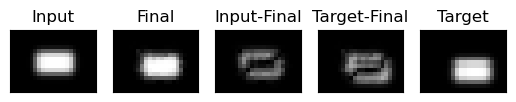

**********************************************************************
/home/bastian/D1/cubedebugging/true1e-2L2controlMRI2FEMtrueRungeKutta done
newTransport = True alpha = 0.01 regularize = L2control loading = MRI2FEM normalize = True
3.1e-02 -> 2.5e-02 -----> 1.1e-02 ( 8  epochs)
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/target.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Populated Input and Target images by function values
Diff in input -0.03770049068094344
Diff in target -0.030380801118169543
evaluating loaded u
Max after eval 1.0961376967991636
vmax= 1.0 vmin 0.0
|In-Target| 0.132
|Target-Final| 0.082


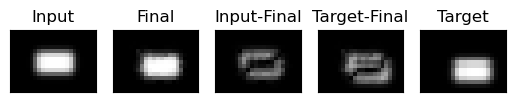

**********************************************************************
/home/bastian/D1/cubedebugging/false1e-2L2controlMRI2FEMtrueCrankNicolson done
newTransport = False alpha = 0.01 regularize = L2control loading = MRI2FEM normalize = True
3.1e-02 -> 2.5e-02 -----> 1.1e-02 ( 8  epochs)
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/target.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Populated Input and Target images by function values
Diff in input -0.03770049068094344
Diff in target -0.030380801118169543
evaluating loaded u
Max after eval 1.094886050499615
vmax= 1.0 vmin 0.0
|In-Target| 0.132
|Target-Final| 0.082


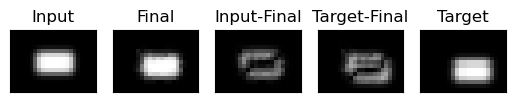

**********************************************************************
/home/bastian/D1/cubedebugging/false1e-2L2controlPic2FENtrueCrankNicolson done
newTransport = False alpha = 0.01 regularize = L2control loading = Pic2FEN normalize = True
9.9e+00 -> 2.8e+00 -----> 2.7e-01 ( 58  epochs)
1.0
1.0
--max 1.7320508075688779 1.7320508075688779
--max 7.149928130638185e-16
Populated Input and Target images by function values
Diff in input 0.09704711909028449
Diff in target 0.09704711909028449
evaluating loaded u
Max after eval 1.0655799454035773
vmax= 1.0 vmin 0.0
|In-Target| 0.108
|Target-Final| 0.033


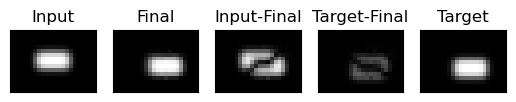

**********************************************************************
/home/bastian/D1/cubedebugging/true1e-2L2controlPic2FENtrueCrankNicolson done
newTransport = True alpha = 0.01 regularize = L2control loading = Pic2FEN normalize = True
9.9e+00 -> 2.8e+00 -----> 2.6e-01 ( 22  epochs)
1.0
1.0
--max 1.7320508075688779 1.7320508075688779
--max 7.149928130638185e-16
Populated Input and Target images by function values
Diff in input 0.09704711909028449
Diff in target 0.09704711909028449
evaluating loaded u
Max after eval 1.0632281620980795
vmax= 1.0 vmin 0.0
|In-Target| 0.108
|Target-Final| 0.033


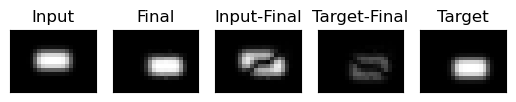

**********************************************************************
/home/bastian/D1/cubedebugging/true1e-2L2controlMRI2FEMtrueRungeKuttaBug done
newTransport = True alpha = 0.01 regularize = L2control loading = MRI2FEM normalize = True
3.1e-02 -> 2.7e-02 -----> 2.6e-02 ( 14  epochs)
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/target.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Populated Input and Target images by function values
Diff in input -0.03770049068094344
Diff in target -0.030380801118169543
evaluating loaded u
Max after eval 1.0034057095792077
vmax= 1.0 vmin 0.0
|In-Target| 0.132
|Target-Final| 0.114


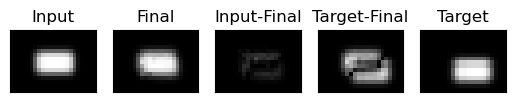

**********************************************************************
/home/bastian/D1/cubedebugging/true1e-4L2controlMRI2FEMtrueexplicitEuler done
newTransport = True alpha = 0.0001 regularize = L2control loading = MRI2FEM normalize = True
3.1e-02 -> 7.1e-03 -----> 5.9e-04 ( 23  epochs)
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/target.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Populated Input and Target images by function values
Diff in input -0.03770049068094344
Diff in target -0.030380801118169543
evaluating loaded u
Max after eval 1.107130769398947
vmax= 1.0 vmin 0.0
|In-Target| 0.132
|Target-Final| 0.023


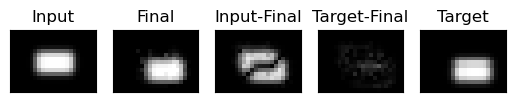

**********************************************************************
/home/bastian/D1/cubedebugging/false1e-4L2controlPic2FENtrueexplicitEuler is running, no loss.txt
**********************************************************************
/home/bastian/D1/cubedebugging/false1e-4L2controlPic2FENtrueRungeKutta is running, no loss.txt
**********************************************************************
/home/bastian/D1/cubedebugging/true1e-4L2controlPic2FENtrueRungeKutta done
newTransport = True alpha = 0.0001 regularize = L2control loading = Pic2FEN normalize = True
9.9e+00 -> 2.8e+00 -----> 2.5e-01 ( 779  epochs)
1.0
1.0
--max 1.7320508075688779 1.7320508075688779
--max 7.149928130638185e-16
Populated Input and Target images by function values
Diff in input 0.09704711909028449
Diff in target 0.09704711909028449
evaluating loaded u
Max after eval 1.067625707521705
vmax= 1.0 vmin 0.0
|In-Target| 0.108
|Target-Final| 0.033


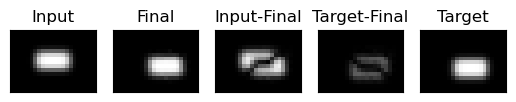

**********************************************************************
/home/bastian/D1/cubedebugging/true1e-4L2controlMRI2FEMtrueRungeKutta done
newTransport = True alpha = 0.0001 regularize = L2control loading = MRI2FEM normalize = True
3.1e-02 -> 7.1e-03 -----> 5.9e-04 ( 24  epochs)
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/target.mgz
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Populated Input and Target images by function values
Diff in input -0.03770049068094344
Diff in target -0.030380801118169543
evaluating loaded u
Max after eval 1.1088180299559598
vmax= 1.0 vmin 0.0
|In-Target| 0.132
|Target-Final| 0.023


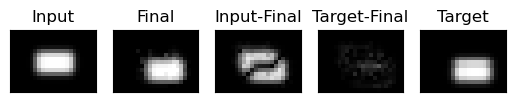

**********************************************************************
/home/bastian/D1/cubedebugging/true1e-4L2controlPic2FENtrueexplicitEuler done
newTransport = True alpha = 0.0001 regularize = L2control loading = Pic2FEN normalize = True
9.9e+00 -> 2.8e+00 -----> 2.5e-01 ( 878  epochs)
1.0
1.0
--max 1.7320508075688779 1.7320508075688779
--max 7.149928130638185e-16
Populated Input and Target images by function values
Diff in input 0.09704711909028449
Diff in target 0.09704711909028449
evaluating loaded u
Max after eval 1.06691409815528
vmax= 1.0 vmin 0.0
|In-Target| 0.108
|Target-Final| 0.033


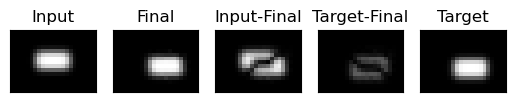

In [12]:
results = {}
for f in folders:
    print("*"*70)
    try:
        # print(f)
        data = json.load(open(f / "hyperparameters.json"))
        try:
            data["Jd_final"]
            # print(str(f))
            print(data["Jd_init"])#, data["Jd_final"])
            print(data["Jd_final"])
        except KeyError:
            pass
    except FileNotFoundError:
        pass
    
    if not (f / "loss.txt").is_file():
        print(f, "is running, no loss.txt")
        continue
    
    done = ", not done"
    
    if (f / "VelocityField.hdf").is_file():
        done = "done"
        
    print(f, done)
        
    if done == "done":
        loss_history = np.genfromtxt(f / "loss.txt", delimiter=',')[:-1]
        initialloss = float(scan_logfile(foldername=str(f)).replace("D", "e"))
        
        print("newTransport =",data["newTransport"],
              "alpha =",data["alpha"],
              "regularize =",data["regularize"],
              "loading =",data["loading"],
              "normalize =",data["normalize"])
        

        results[("newTransport =" + str(data["newTransport"]),
              "alpha =" + str(data["alpha"]),
              "regularize =" + data["regularize"],
              "loading =" + data["loading"],
              "normalize =" + str(data["normalize"]),
                "timestep=" + data["timestepping"])] = (format(initialloss, ".3e"), 
                                                        # format(loss_history[0], ".3e"),
                                                        format(loss_history[-1], ".3e"))
    
        print(format(initialloss, ".1e"), "->",  format(loss_history[0], ".1e"), "----->", format(loss_history[-1], ".1e"), "(", len(loss_history), " epochs)")
    try:
        inputimage, targetimage, finalimage = input_target(foldername=f, imgtype=IMAGETYPE, 
                                                               always_load_image=False)
        plot_all(inputimage, finalimage, targetimage)
        
        continue
        inputimage, targetimage, finalimage = input_target(foldername=f, imgtype=IMAGETYPE, 
                                                               always_load_image=False)
        plot_all(inputimage, finalimage, targetimage)
    except AssertionError:
        pass

In [13]:
results

{('newTransport =True',
  'alpha =0.01',
  'regularize =L2control',
  'loading =MRI2FEM',
  'normalize =True',
  'timestep=explicitEuler'): ('3.071e-02', '1.094e-02'),
 ('newTransport =True',
  'alpha =0.01',
  'regularize =L2control',
  'loading =MRI2FEM',
  'normalize =True',
  'timestep=RungeKutta'): ('3.071e-02', '1.095e-02'),
 ('newTransport =False',
  'alpha =0.01',
  'regularize =L2control',
  'loading =MRI2FEM',
  'normalize =True',
  'timestep=CrankNicolson'): ('3.071e-02', '1.094e-02'),
 ('newTransport =False',
  'alpha =0.01',
  'regularize =L2control',
  'loading =Pic2FEN',
  'normalize =True',
  'timestep=CrankNicolson'): ('9.851e+00', '2.683e-01'),
 ('newTransport =True',
  'alpha =0.01',
  'regularize =L2control',
  'loading =Pic2FEN',
  'normalize =True',
  'timestep=CrankNicolson'): ('9.851e+00', '2.641e-01'),
 ('newTransport =True',
  'alpha =0.01',
  'regularize =L2control',
  'loading =MRI2FEM',
  'normalize =True',
  'timestep=RungeKuttaBug'): ('3.071e-02', '2.606e

In [14]:
image2 = nibabel.load(datadir / "input.mgz")
aff = image2.affine
inputimage = image2.get_fdata()
image2 = nibabel.load(datadir / "target.mgz")
targetimage = image2.get_fdata()

In [15]:
#nibabel.save(nibabel.Nifti1Image(targetimage[nx:-nx, :, :], affine=aff), datadir / "target.mgz")
#nibabel.save(nibabel.Nifti1Image(inputimage[nx:-nx, :, :], affine=aff), datadir / "input.mgz")

In [16]:
nx=0

In [17]:
targetimage.shape

(16, 22, 1)

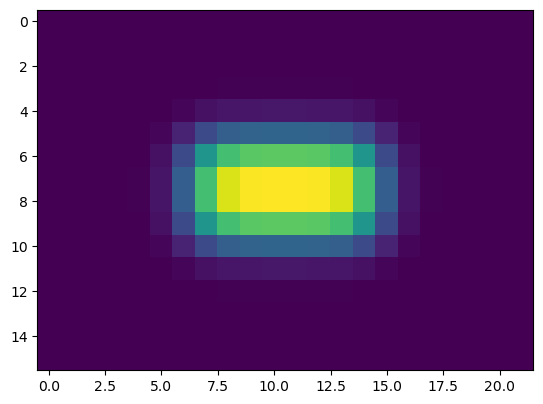

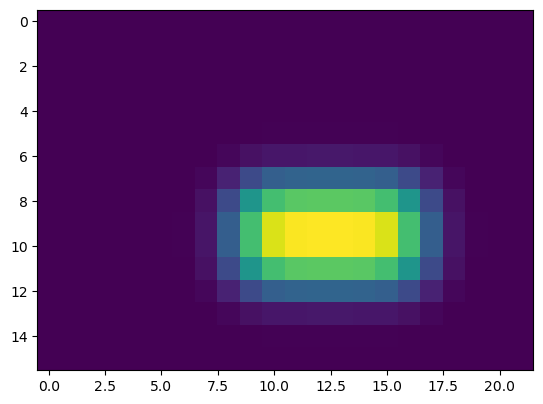

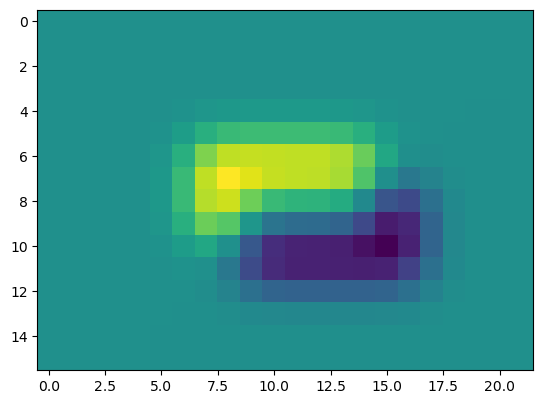

In [18]:
plt.imshow(inputimage)#[nx:-nx, :, 0])
plt.show()
plt.imshow(targetimage)#[nx:-nx, :, 0])
plt.show()
plt.imshow(inputimage-targetimage)#[nx:-nx, :, 0]-targetimage[nx:-nx, :, 0])

In [19]:
%ls

analyze_hyperparameters.py         Optimize3d.py
checkjobs.py                       Optimize.py
cleanslurm.py                      Pic2Fen.py
config.py                          preconditioning_overloaded.py
CreateDeformedImage.py             preconditioning.py
cubedebugging/                     __pycache__/
debug/                             searchjobs.py
debugg-registration-results.ipynb  shuttle_goal.png
debug.slurm                        shuttle_mid.png
DGTransportOrig.py                 shuttle_small.png
DGTransport.py                     slurm/
interpolate_example.py             sts120-s-028.jpg
interpolate.slurm                  submit.slurm
ipopt_solver.py                    SUPGTransport.py
KILLED_JOBS.txt                    systematicdebug/
launch_hyperparameters.sh          test/
mridata_3d/                        testdata_2d/
mri_utils/                         testdata_3d/
obsolete_outputs/                  tests/
old_preconditioning_overloaded.py  transformation_overloaded.

In [20]:
FName = str(datadir / "input.mgz")
FName2 = str(datadir / "input_rot.mgz")

rawF = nibabel.load(FName2).get_fdata()

In [21]:
rawF.max()

0.9367520809173584

In [22]:
normalize = True

In [23]:
mesh1, img1, N1 = Pic2Fen.Pic2FEM(FName, mesh=None, degree=1)
Space = FunctionSpace(mesh1, "DG", 1)

if normalize:
    print(np.max(img1.vector()[:]))
    img1.vector()[:] /= np.max(img1.vector()[:])
    img1.vector()[:] = np.where(img1.vector()[:] < 0, 0, img1.vector()[:])

img1 = project(sqrt(inner(img1, img1)), Space)

assert np.min(img1.vector()[:]) >= -1e-12

1.0


In [24]:
mesh2, img2, N2 = MRI2FEM.read_image(hyperparameters={"image":FName2, "state_functionspace": "DG", "state_functiondegree":1}, 
                                     name="image", mesh=None, normalize=normalize)

Loading /home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d/input_rot.mgz
dimension of image: (22, 16, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image


In [25]:
from fenics import plot

In [26]:
print(np.mean(rawF))
print(assemble(img1*dx(domain=mesh1)) / assemble(1*dx(domain=mesh1)))
print(assemble(img2*dx(domain=mesh2)) / assemble(1*dx(domain=mesh2)))

0.09090909075485873
0.055651008567609635
0.13474760977122635


In [27]:
img1.vector()[:].shape

(2112,)

In [28]:
xy1 = img1.function_space().tabulate_dof_coordinates()
xy2 = img2.function_space().tabulate_dof_coordinates()

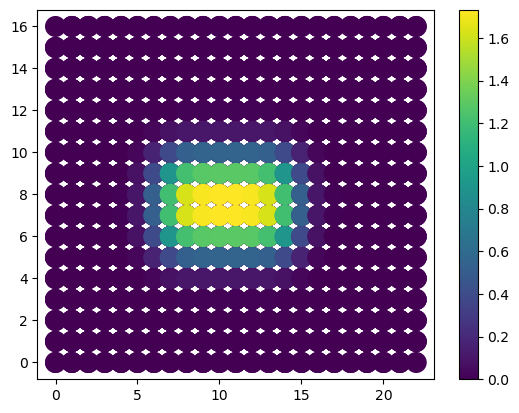

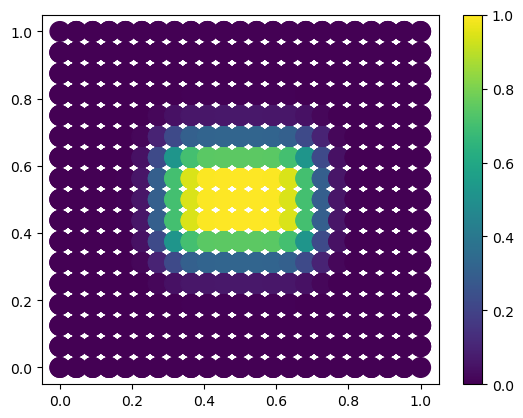

2.0466628511991956


In [29]:
for xy, c in zip([xy1, xy2],[img1.vector()[:], img2.vector()[:]]):
    plt.scatter(x=xy[:,0], y=xy[:,1], c=c, s=200)
    plt.colorbar()
    plt.show()
print(np.mean(np.abs(img1.vector()[:] - img2.vector()[:])) / np.mean(np.abs(img1.vector()[:])))

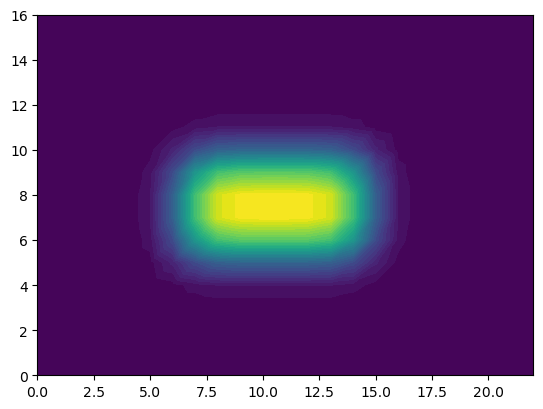

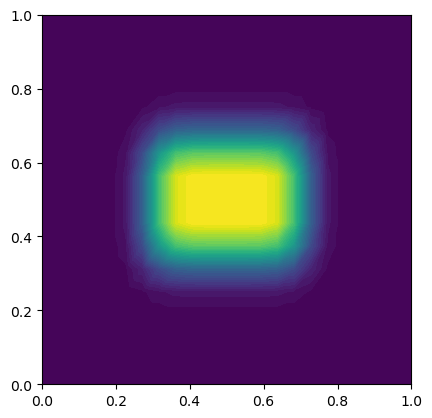

In [30]:
plot(img1)
plt.show()
plot(img2)